In [2]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from torch import nn, optim

import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

Предсказание погоды на следующий день: 
Будет дождь, если rainfall >=1

In [4]:
df = pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [5]:
df.shape

(145460, 23)

Удалим столбцы

In [7]:
cols = ['Rainfall', 'Humidity3pm', 'Pressure9am', 'RainToday', 'RainTomorrow']

df = df[cols]

Удаление строк с пропущенными значениями

In [9]:
df = df.dropna()
df.head()

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,No,No
1,0.0,25.0,1010.6,No,No
2,0.0,30.0,1007.6,No,No
3,0.0,16.0,1017.6,No,No
4,1.0,33.0,1010.8,No,No


Преобразование данных стобца

In [11]:
df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)

C:\Users\Aleksei\AppData\Local\Temp\ipykernel_10060\3734455367.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
C:\Users\Aleksei\AppData\Local\Temp\ipykernel_10060\3734455367.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['RainT

In [12]:
df[df['RainTomorrow']==0.0].count()

Rainfall        97103
Humidity3pm     97103
Pressure9am     97103
RainToday       97103
RainTomorrow    97103
dtype: int64

In [13]:
df[df['RainTomorrow']==1.0].count()

Rainfall        27586
Humidity3pm     27586
Pressure9am     27586
RainToday       27586
RainTomorrow    27586
dtype: int64

Классы несбалансированы

In [15]:
X = df[['Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am']]
y = df[['RainTomorrow']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

Преобразуем в тензор

In [17]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([99751, 4]) torch.Size([99751])
torch.Size([24938, 4]) torch.Size([24938])


#NN

In [19]:

class Net(nn.Module):

  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 8)
    self.fc2 = nn.Linear(8, 4)
    self.fc3 = nn.Linear(4, 1)
    
    # torch.nn.init.xavier_uniform_(self.fc1.weight) 

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

In [20]:
criterion = nn.BCELoss()

In [21]:
device = torch.device( "cpu")

In [22]:
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

In [23]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

In [24]:
net = Net(4)
optimizer = optim.Adam(net.parameters(), lr=0.0001)
net = net.to(device)

criterion = criterion.to(device)

for epoch in range(2000):

    train_loss = 0
    y_pred = net(X_train)
    
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
        
    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    if epoch % 100 == 0:

          y_test_pred = net(X_test)
          y_test_pred = torch.squeeze(y_test_pred)

          test_loss = criterion(y_test_pred, y_test)

          test_acc = calculate_accuracy(y_test, y_test_pred)
          print(
    f'''epoch {epoch}
    Test  set - loss: {test_loss}, accuracy: {test_acc}
    ''')

epoch 0
    Test  set - loss: 7.164628982543945, accuracy: 0.2216697335243225
    
epoch 100
    Test  set - loss: 0.5720775723457336, accuracy: 0.7959740161895752
    
epoch 200
    Test  set - loss: 0.5436041355133057, accuracy: 0.7788916230201721
    
epoch 300
    Test  set - loss: 0.5333548784255981, accuracy: 0.7793327569961548
    
epoch 400
    Test  set - loss: 0.515479326248169, accuracy: 0.7796936631202698
    
epoch 500
    Test  set - loss: 0.4807443916797638, accuracy: 0.7794530391693115
    
epoch 600
    Test  set - loss: 0.4678131341934204, accuracy: 0.7808966040611267
    
epoch 700
    Test  set - loss: 0.45576098561286926, accuracy: 0.784866452217102
    
epoch 800
    Test  set - loss: 0.4444392919540405, accuracy: 0.7911219596862793
    
epoch 900
    Test  set - loss: 0.43364790081977844, accuracy: 0.7985002994537354
    
epoch 1000
    Test  set - loss: 0.42420724034309387, accuracy: 0.8103296160697937
    
epoch 1100
    Test  set - loss: 0.41717204451560974, a

In [25]:
MODEL_PATH = 'model.pth'

torch.save(net, MODEL_PATH)

In [26]:
net = torch.load(MODEL_PATH)

C:\Users\Aleksei\AppData\Local\Temp\ipykernel_10060\804352145.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load(MODEL_PATH)


In [27]:
classes = ['No rain', 'Raining']

y_pred = net(X_test)

y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()

print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     No rain       0.85      0.96      0.90     19413
     Raining       0.74      0.40      0.52      5525

    accuracy                           0.84     24938
   macro avg       0.79      0.68      0.71     24938
weighted avg       0.82      0.84      0.82     24938



In [28]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

Training with learning rate: 1e-05
Training with learning rate: 0.0001
Training with learning rate: 0.001
Training with learning rate: 0.01
Training with learning rate: 0.1
Optimal learning rate: 0.0001


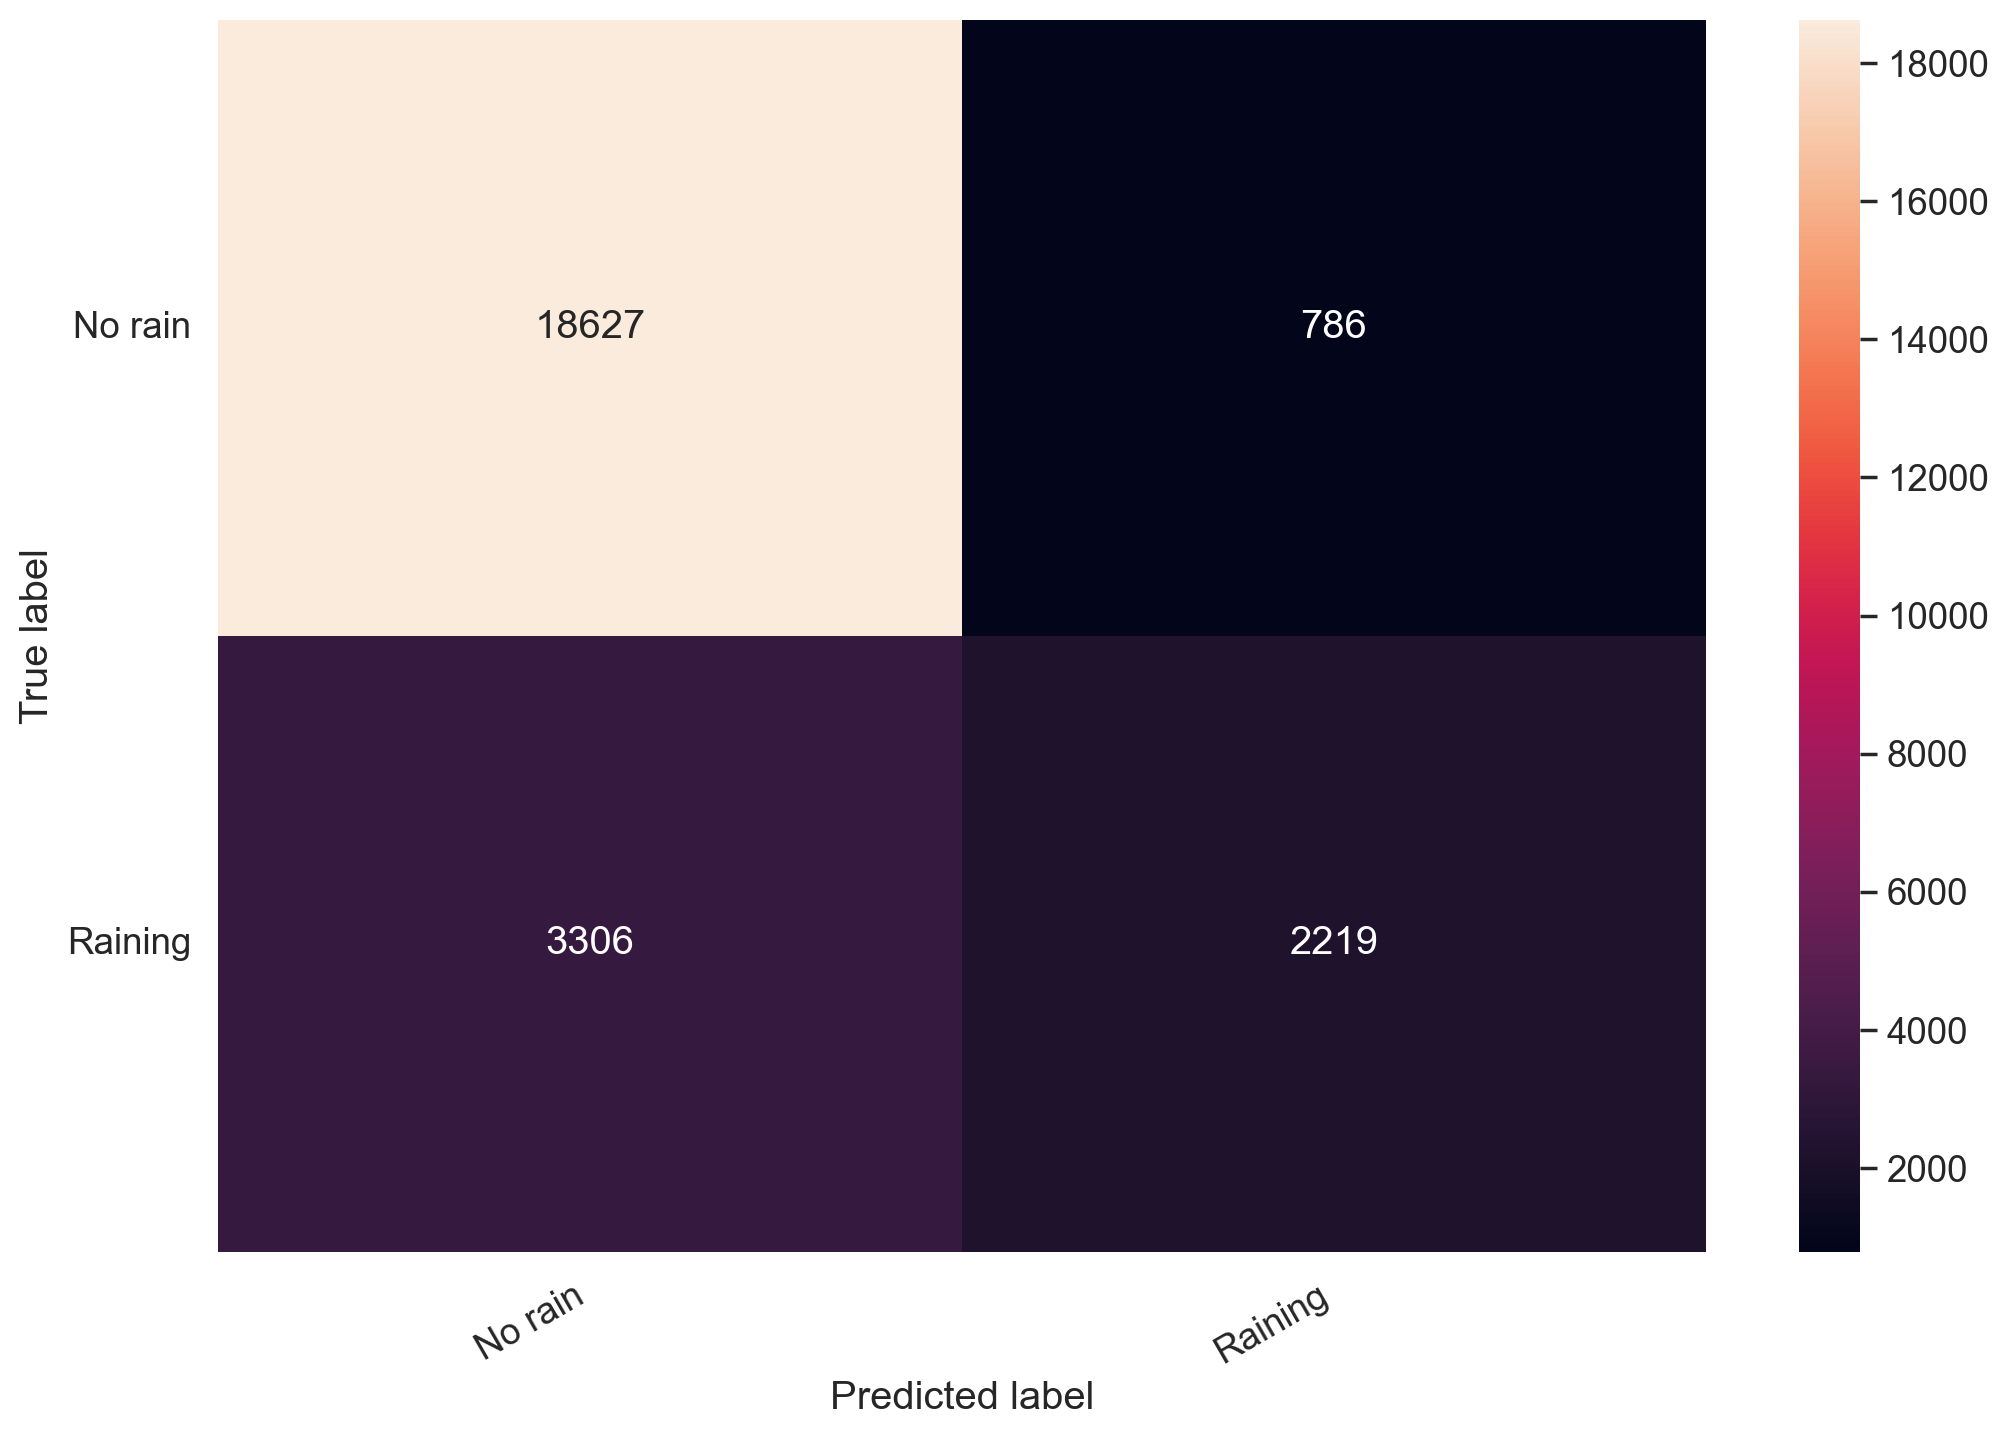

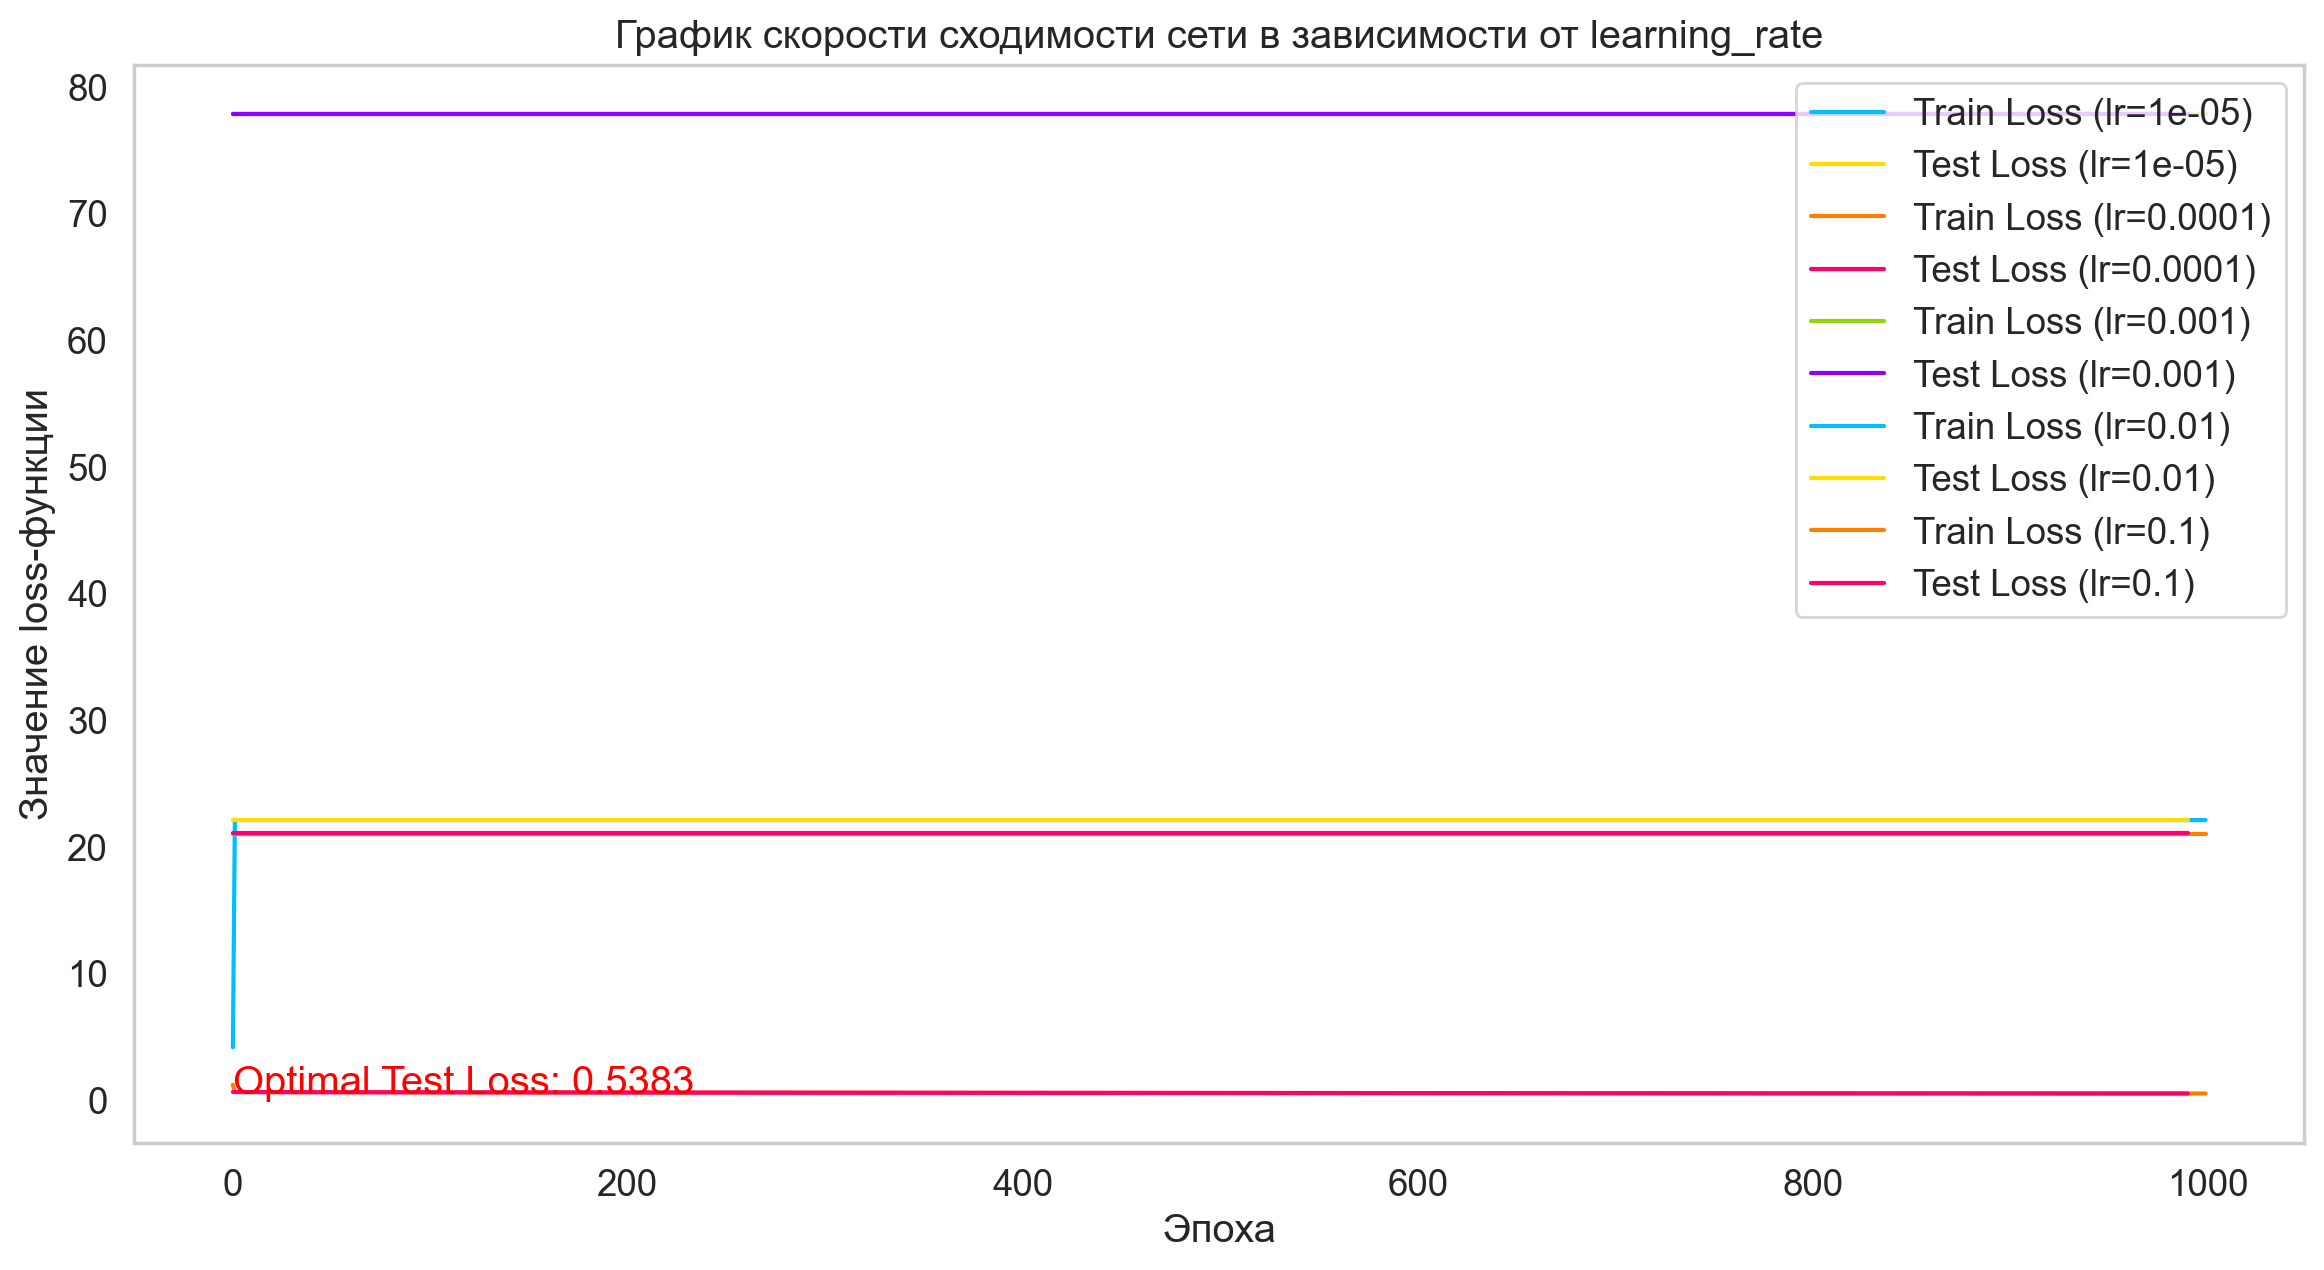

In [29]:
# 1. Проведите эксперименты, постройте график скорости cходимости сети в зависимости от learning_rate, 
# выберите оптимальное значение.

def train_and_evaluate(learning_rate):
    net = Net(4)
    criterion = nn.BCELoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate)
    
    train_losses = []
    test_losses = []

    for epoch in range(1000):
        optimizer.zero_grad()
        y_pred = net(X_train).squeeze()
        train_loss = criterion(y_pred, y_train.float())
        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.item())
        
        if epoch % 10 == 0:
            y_test_pred = net(X_test).squeeze()
            test_loss = criterion(y_test_pred, y_test.float())
            test_losses.append(test_loss.item())

    return train_losses, test_losses

learning_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]
train_loss_dict = {}
test_loss_dict = {}
test_loss_summary = {} 

for lr in learning_rates:
    print(f'Training with learning rate: {lr}')
    train_losses, test_losses = train_and_evaluate(lr)
    train_loss_dict[lr] = train_losses
    test_loss_dict[lr] = test_losses
    test_loss_summary[lr] = test_losses[-1]

optimal_lr = min(test_loss_summary, key=test_loss_summary.get)
print(f'Optimal learning rate: {optimal_lr}')

plt.figure(figsize=(14, 7))

for lr in learning_rates:
    plt.plot(train_loss_dict[lr], label=f'Train Loss (lr={lr})')
    plt.plot(range(0, 1000, 10), test_loss_dict[lr], label=f'Test Loss (lr={lr})')

plt.title('График скорости cходимости сети в зависимости от learning_rate')
plt.xlabel('Эпоха')
plt.ylabel('Значение loss-функции')
plt.legend()
plt.grid()
plt.text(0, test_loss_summary[optimal_lr] + 0.01, f'Optimal Test Loss: {test_loss_summary[optimal_lr]:.4f}', color='red')
plt.show()
    

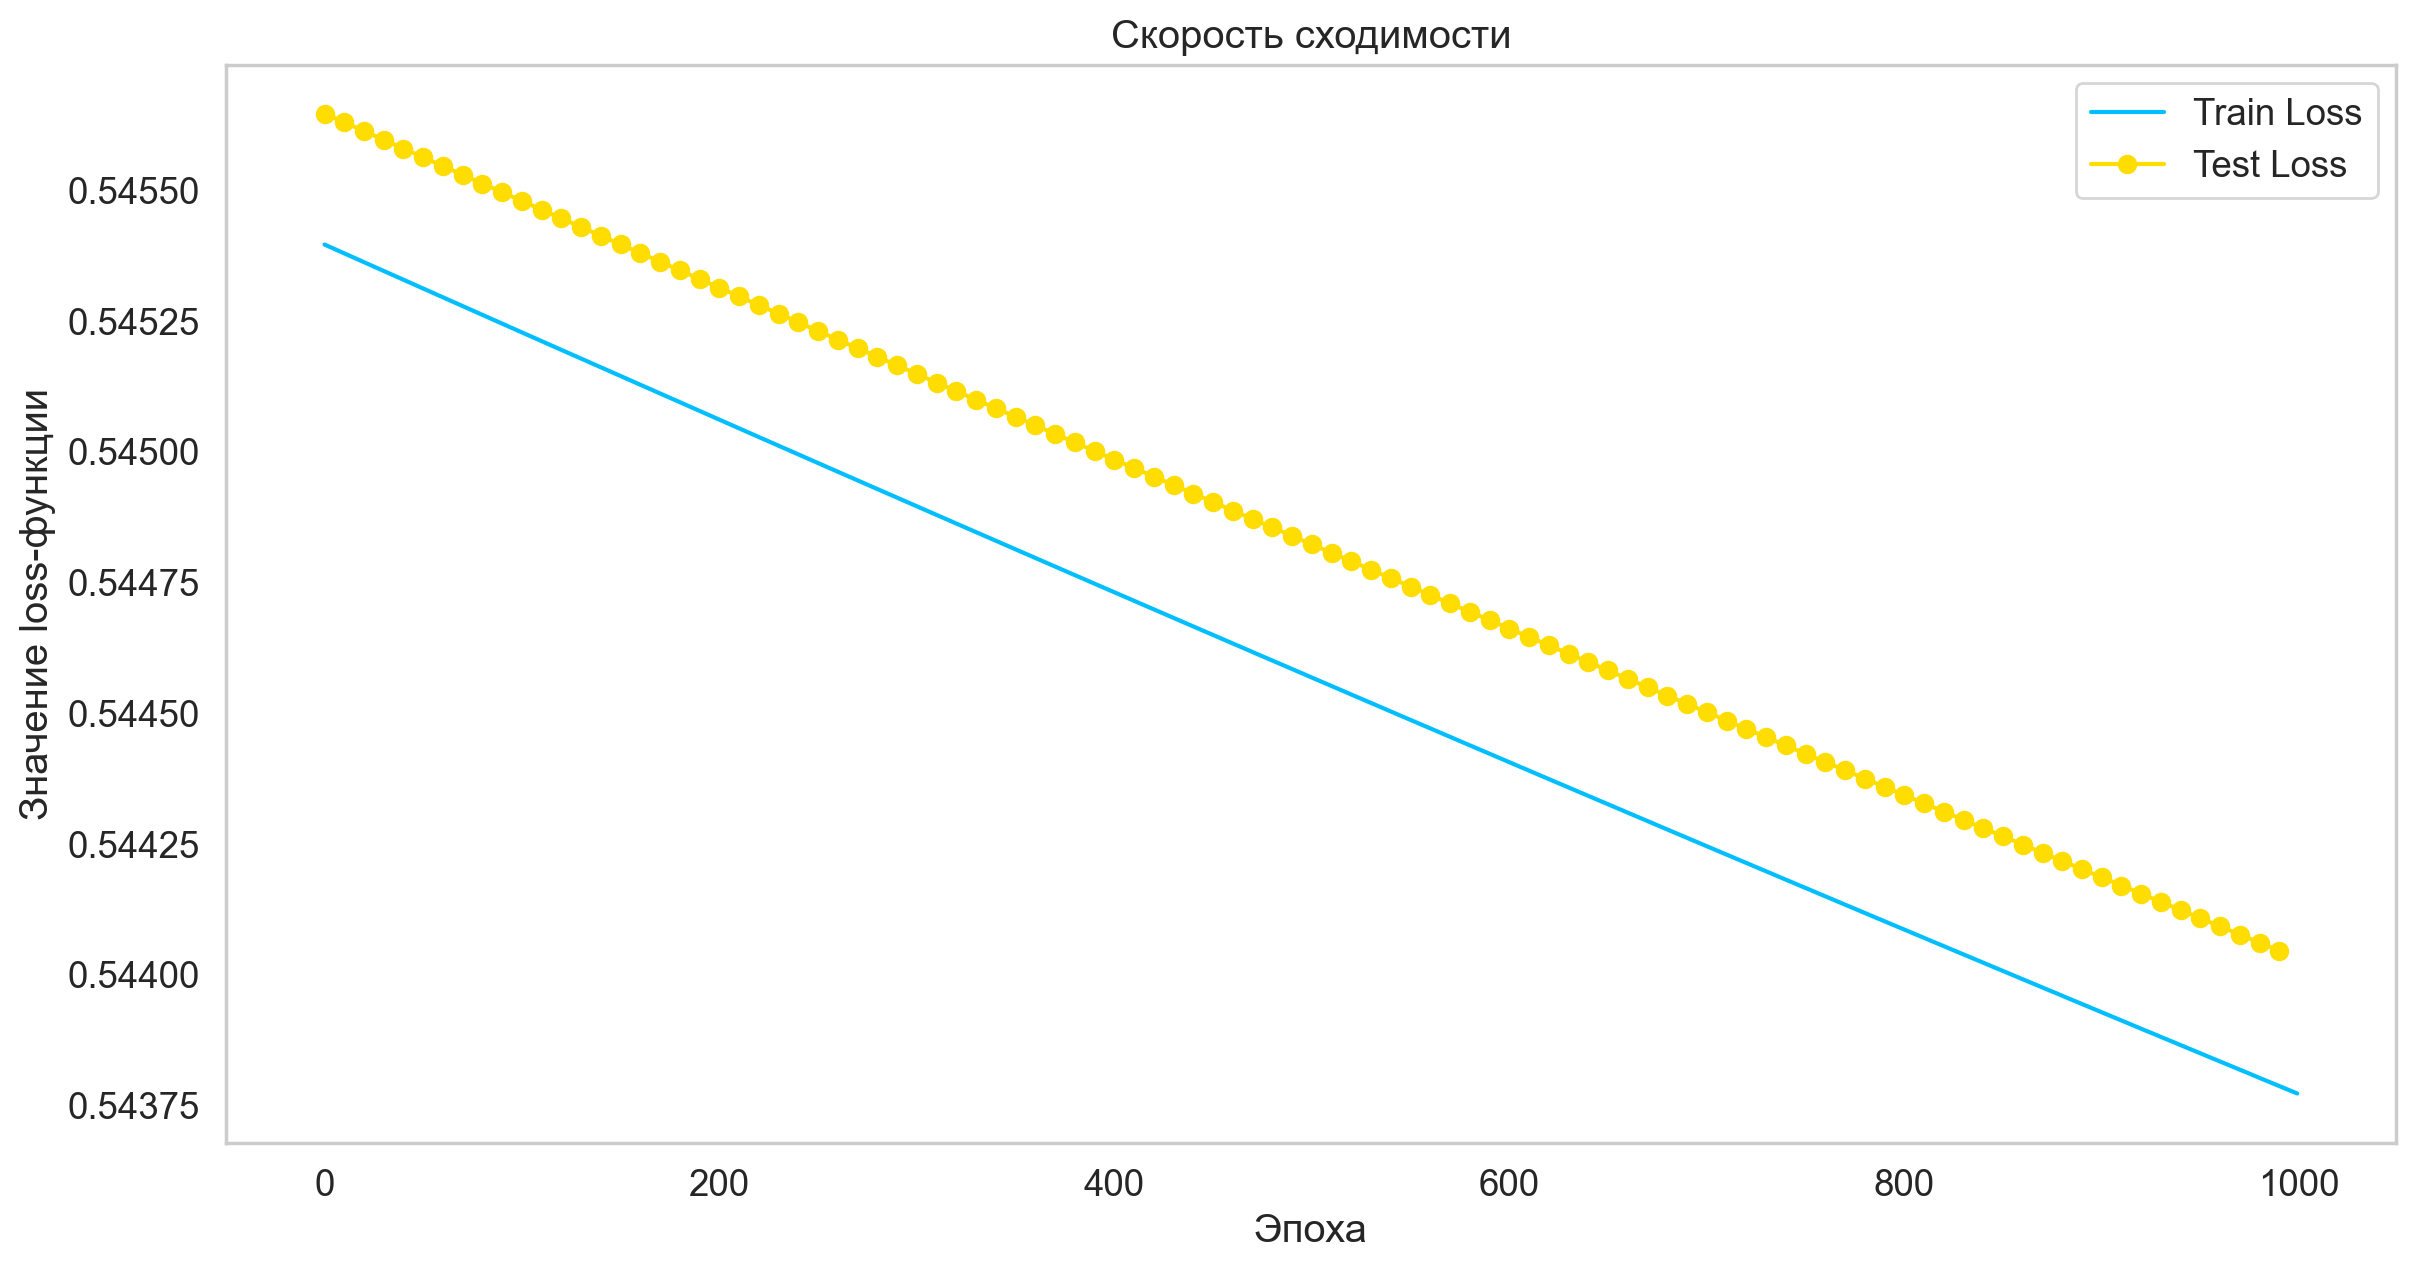

In [30]:
# 2. Примените нормализацию данных. Исследуйте скорость сходимости.

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

X_train = torch.from_numpy(X_train).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
X_test = torch.from_numpy(X_test).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

train_losses, test_losses = train_and_evaluate(optimal_lr)

plt.figure(figsize=(14, 7))
plt.plot(train_losses, label='Train Loss')
plt.plot(range(0, 1000, 10), test_losses, label='Test Loss', marker='o')

plt.title('Скорость сходимости')
plt.xlabel('Эпоха')
plt.ylabel('Значение loss-функции')
plt.legend()
plt.grid()
plt.show()

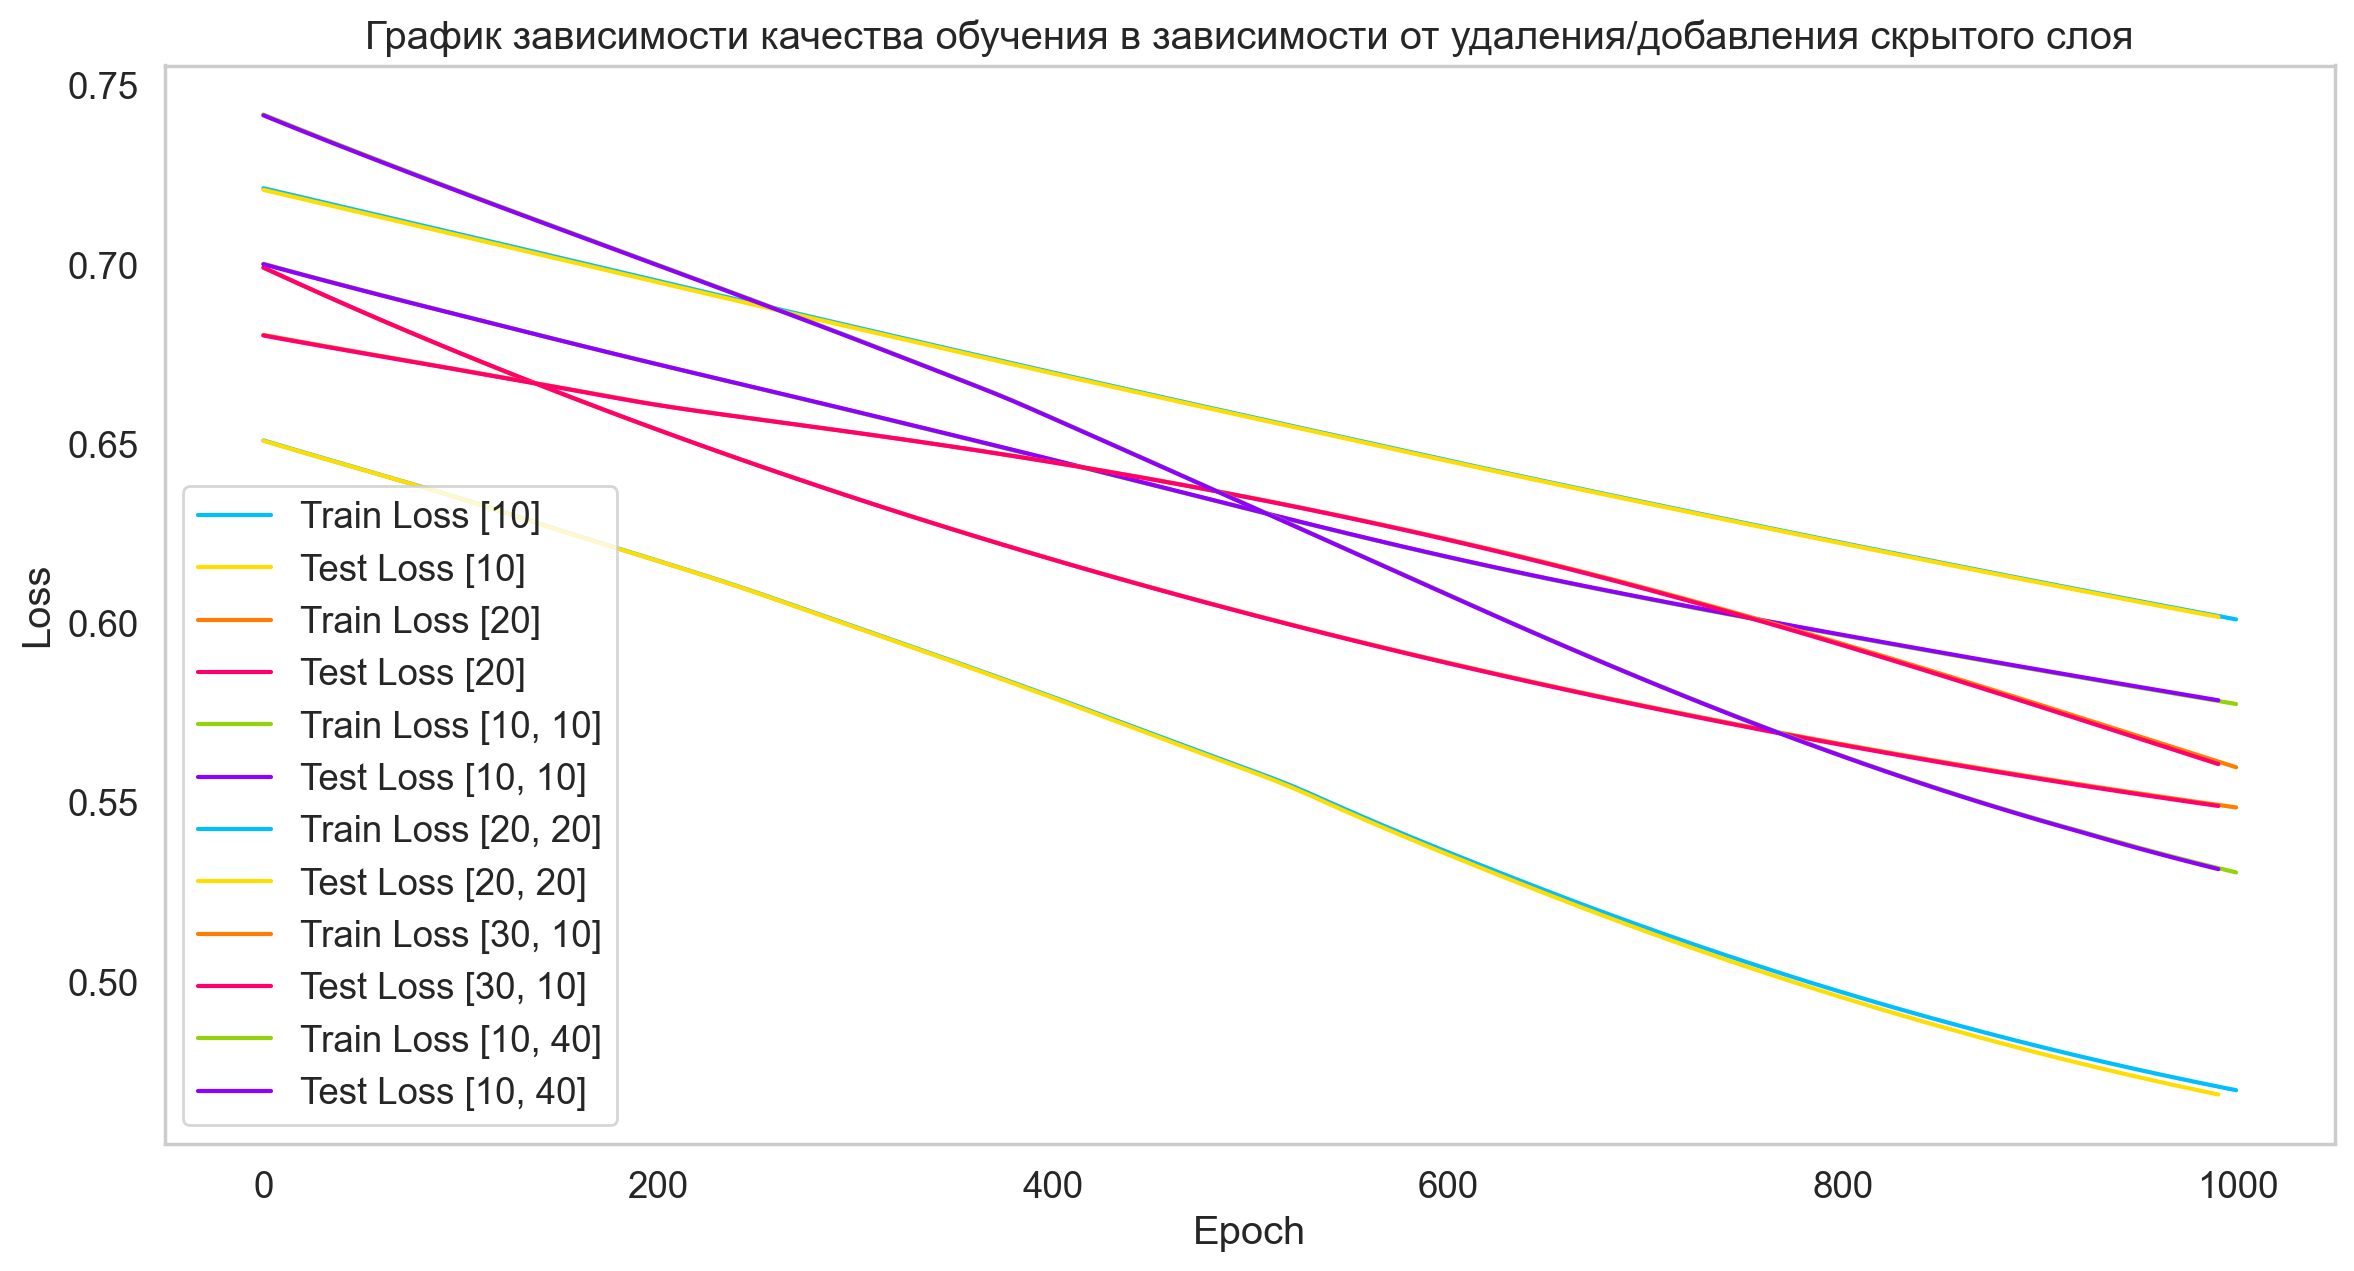

       Слои  Значение loss-функции
0      [10]               0.601691
1      [20]               0.548965
2  [10, 10]               0.578436
3  [20, 20]               0.468482
4  [30, 10]               0.560649
5  [10, 40]               0.531345


In [31]:
# 3. Измените струтуру сети. Постройте график/таблицу зависимости качества обучения в зависимости от удаления/добавления
# скрытого слоя, Удаления/добавления нейронов в каждом слое.

class Networkkkk(nn.Module):
    def __init__(self, input_size, hidden_layers):
        super(Networkkkk, self).__init__()
        self.layers = nn.Sequential()
        last_size = input_size
        
        for i, layer_size in enumerate(hidden_layers):
            self.layers.add_module(f'fc{i+1}', nn.Linear(last_size, layer_size))
            self.layers.add_module(f'activation{i+1}', nn.ReLU())
            last_size = layer_size
        
        self.layers.add_module('output', nn.Linear(last_size, 1))
    
    def forward(self, x):
        return torch.sigmoid(self.layers(x))


def train_and_evaluate(hidden_layers, learning_rate):
    net = Networkkkk(4, hidden_layers)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    for epoch in range(1000):
        optimizer.zero_grad()
        y_pred = net(X_train).squeeze()
        train_loss = criterion(y_pred, y_train.float())
        train_loss.backward()
        optimizer.step()
        
        train_losses.append(train_loss.item())

        if epoch % 10 == 0:
            y_test_pred = net(X_test).squeeze()
            test_loss = criterion(y_test_pred, y_test.float())
            test_losses.append(test_loss.item())

    return train_losses, test_losses




layers = [
    [10],               
    [20],              
    [10, 10],          
    [20, 20],           
    [30, 10],           
    [10, 40]            
]
results = {}

for layer in layers:
    train_losses, test_losses = train_and_evaluate(layer, optimal_lr)
    results[str(layer)] = {
        'train_loss': train_losses,
        'test_loss': test_losses,
        'final_test_loss': test_losses[-1] if test_losses else None
    }

plt.figure(figsize=(14, 7))

for config, data in results.items():
    plt.plot(data['train_loss'], label=f'Train Loss {config}')
    plt.plot(range(0, 1000, 10), data['test_loss'], label=f'Test Loss {config}')

plt.title('График зависимости качества обучения в зависимости от удаления/добавления скрытого слоя')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

results_df = pd.DataFrame({
    'Слои': [k for k in results.keys()],
    'Значение loss-функции': [v['final_test_loss'] for v in results.values()]
})
print(results_df)

ReLU
Sigmoid
Tanh
LeakyReLU
ELU


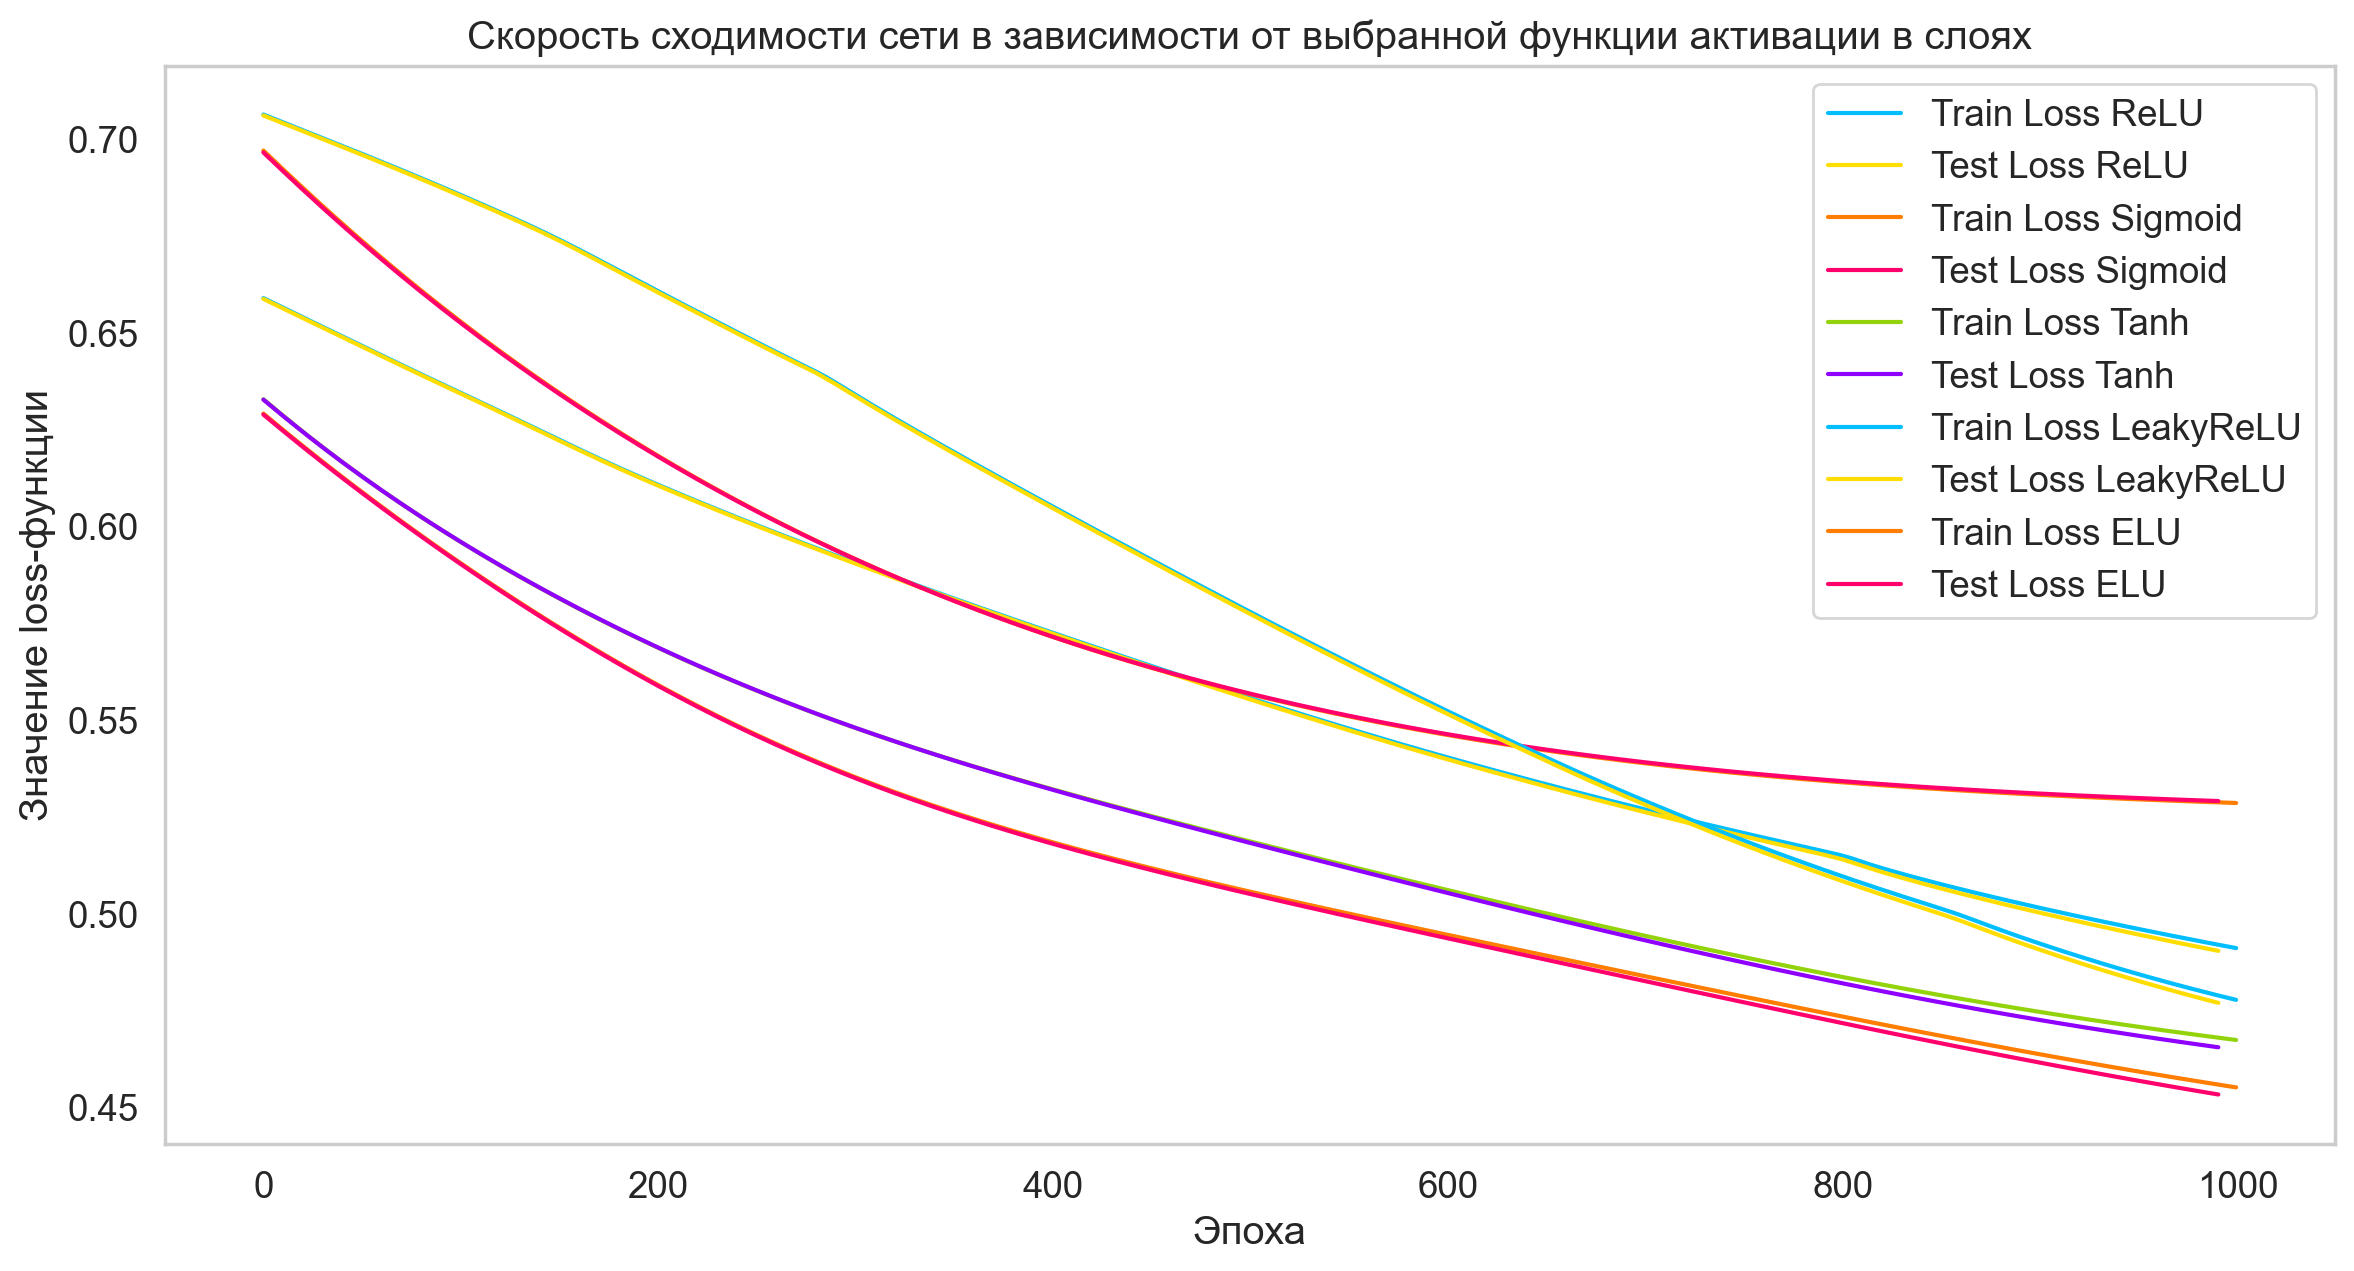

  Функция активации  Значение loss-функции
0              ReLU               0.490343
1           Sigmoid               0.529022
2              Tanh               0.465453
3         LeakyReLU               0.476919
4               ELU               0.453264


In [32]:
# 4. Исследуйте скорость сходимости сети в зависимости от выбранной функции активации в слоях.
# https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

class Networkkk(nn.Module):
    def __init__(self, input_size, hidden_layers, activation_fn):
        super(Networkkk, self).__init__()
        self.layers = nn.Sequential()
        last_size = input_size
        
        for i, layer_size in enumerate(hidden_layers):
            self.layers.add_module(f'fc{i+1}', nn.Linear(last_size, layer_size))
            self.layers.add_module(f'activation{i+1}', activation_fn)
            last_size = layer_size
        
        self.layers.add_module('output', nn.Linear(last_size, 1))
    
    def forward(self, x):
        return torch.sigmoid(self.layers(x))


def train_and_evaluate(hidden_layers, activation_fn, learning_rate=optimal_lr):
    net = Networkkk(4, hidden_layers, activation_fn)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    for epoch in range(1000):
        optimizer.zero_grad()
        y_pred = net(X_train).squeeze()
        train_loss = criterion(y_pred, y_train.float())
        train_loss.backward()
        optimizer.step()
        
        train_losses.append(train_loss.item())

        if epoch % 10 == 0:
            y_test_pred = net(X_test).squeeze()
            test_loss = criterion(y_test_pred, y_test.float())
            test_losses.append(test_loss.item())

    return train_losses, test_losses


activation_functions = {
    'ReLU': nn.ReLU(),
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh(),
    'LeakyReLU': nn.LeakyReLU(),
    'ELU': nn.ELU(),
}

results = {}

for name, activation_fn in activation_functions.items():
    print(name)
    hidden_layers = [20, 20] 
    train_losses, test_losses = train_and_evaluate(hidden_layers, activation_fn)
    results[name] = {
        'train_loss': train_losses,
        'test_loss': test_losses,
        'final_test_loss': test_losses[-1] if test_losses else None
    }

plt.figure(figsize=(14, 7))

for name, data in results.items():
    plt.plot(data['train_loss'], label=f'Train Loss {name}')
    plt.plot(range(0, 1000, 10), data['test_loss'], label=f'Test Loss {name}')

plt.title('Скорость сходимости сети в зависимости от выбранной функции активации в слоях')
plt.xlabel('Эпоха')
plt.ylabel('Значение loss-функции')
plt.legend()
plt.grid()
plt.show()

results_df = pd.DataFrame({
    'Функция активации': [k for k in results.keys()],
    'Значение loss-функции': [v['final_test_loss'] for v in results.values()]
})
print(results_df)

SGD
Adam
AdamW
RMSprop
Adagrad


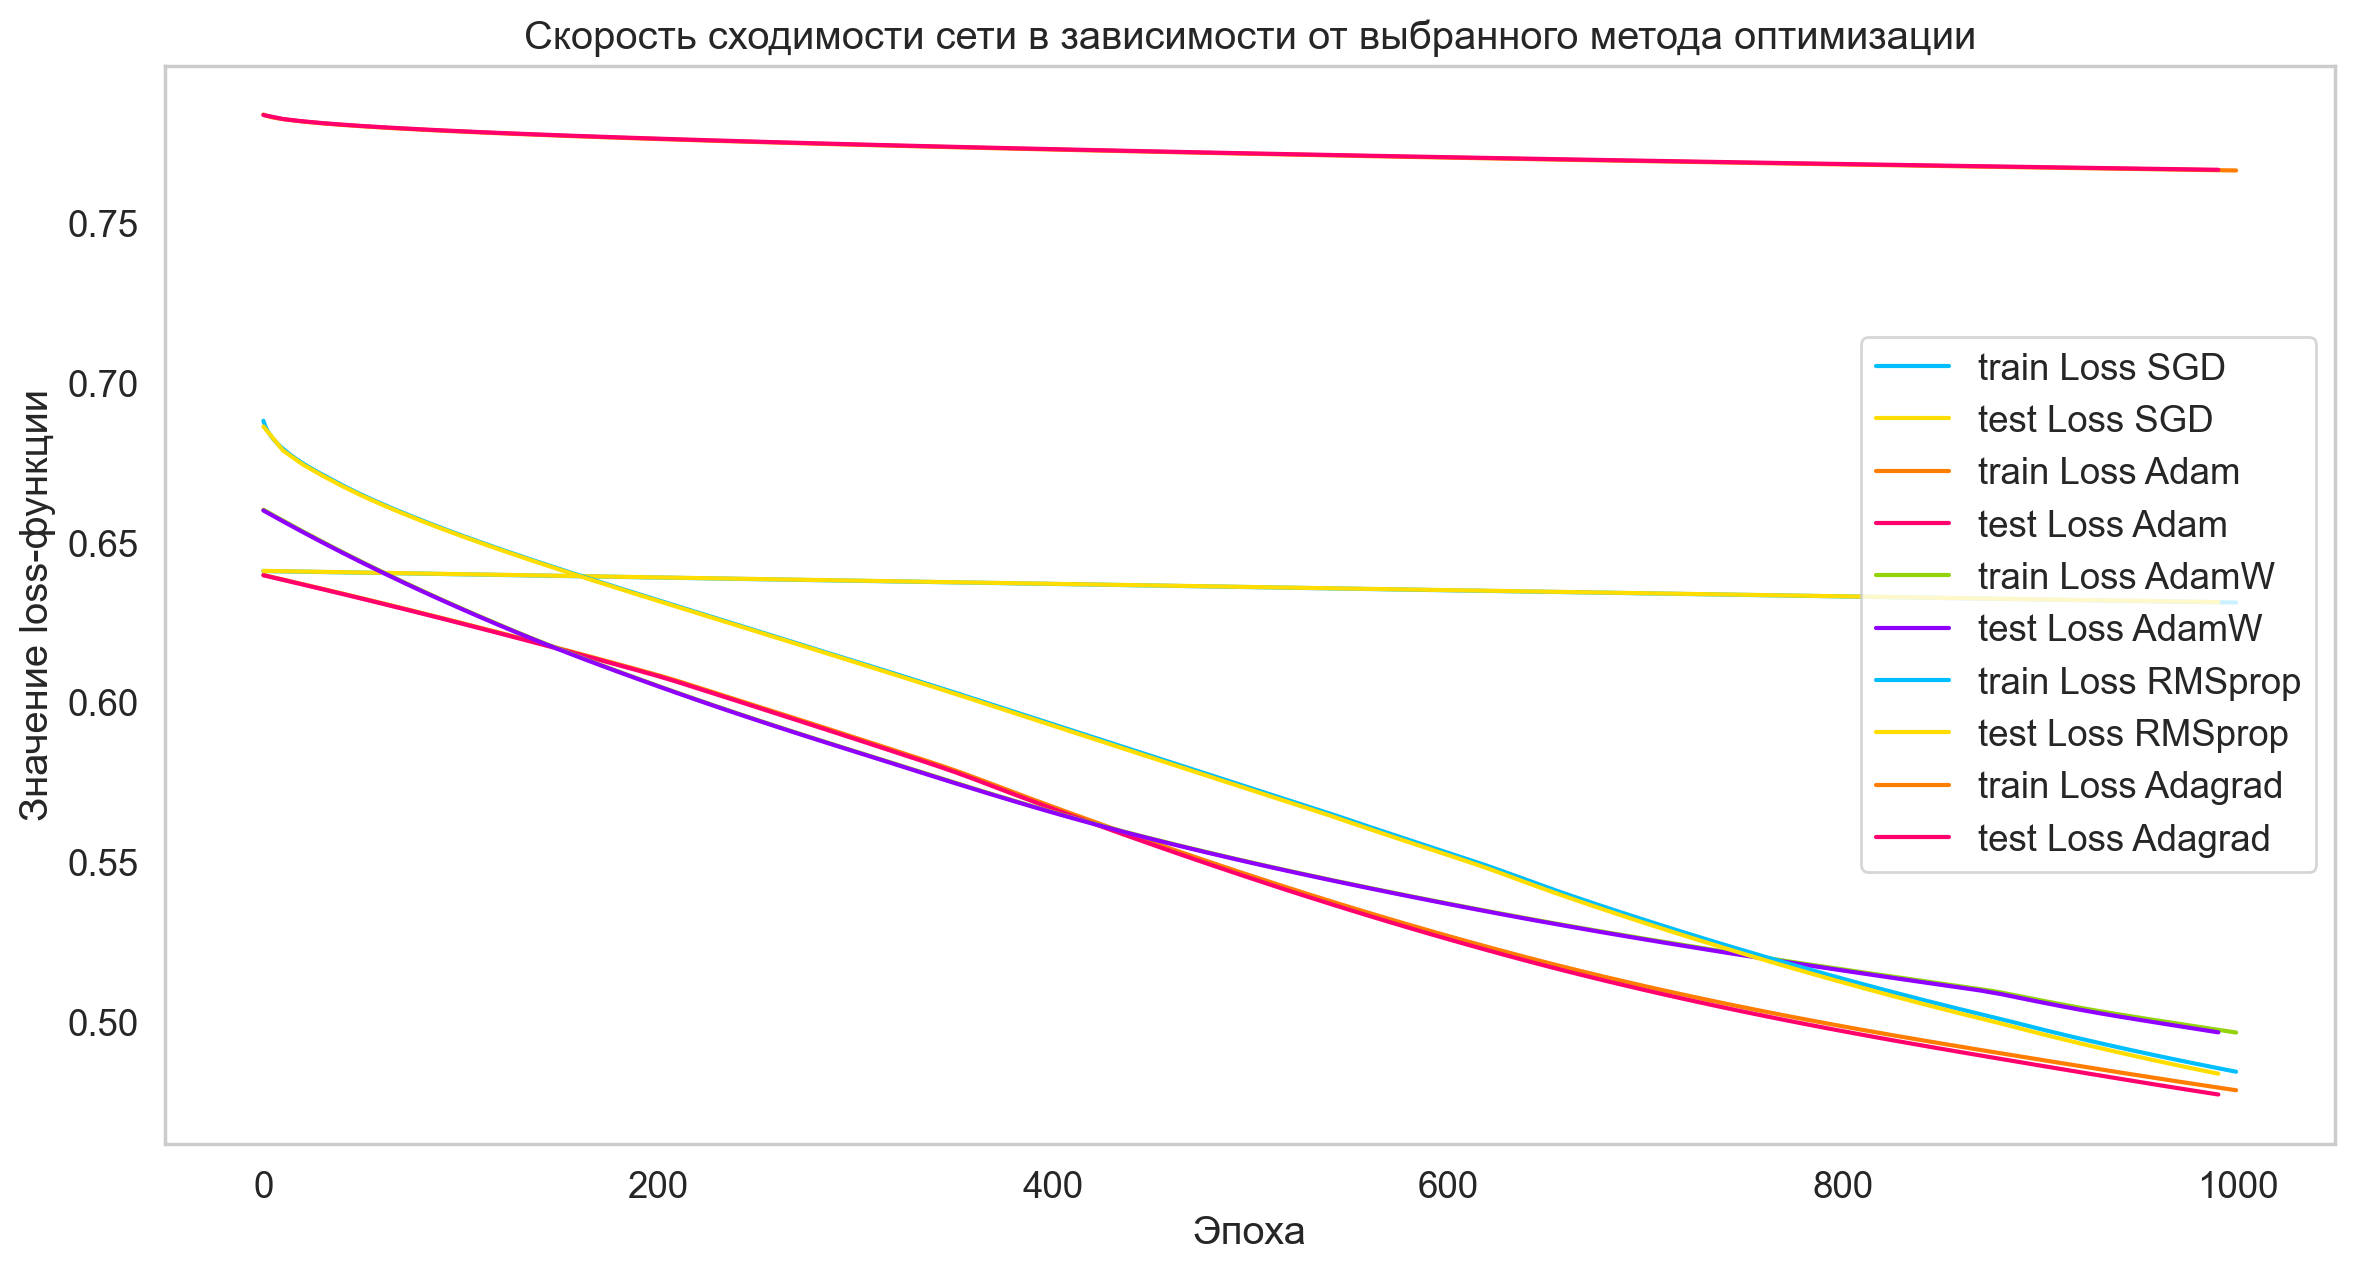

  Алгоритм оптимизации  Значение loss-функции
0                  SGD               0.631340
1                 Adam               0.477301
2                AdamW               0.496741
3              RMSprop               0.483796
4              Adagrad               0.766587


In [33]:
# 5. Исследуйте скорость сходимости сети в зависимости от выбранного метода оптимизации.
# https://pytorch.org/docs/stable/optim.html

class Networkkk(nn.Module):
    def __init__(self, input_size, hidden_layers, activation_fn):
        super(Networkkk, self).__init__()
        self.layers = nn.Sequential()
        last_size = input_size
        
        for i, layer_size in enumerate(hidden_layers):
            self.layers.add_module(f'fc{i+1}', nn.Linear(last_size, layer_size))
            self.layers.add_module(f'activation{i+1}', activation_fn)
            last_size = layer_size
        
        self.layers.add_module('output', nn.Linear(last_size, 1))
    
    def forward(self, x):
        return torch.sigmoid(self.layers(x))


def train_and_evaluate(hidden_layers, activation_fn, optimizer_class, learning_rate=optimal_lr):
    net = Networkkk(4, hidden_layers, activation_fn)
    criterion = nn.BCELoss()
    optimizer = optimizer_class(net.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    for epoch in range(1000):
        optimizer.zero_grad()
        y_pred = net(X_train).squeeze()
        train_loss = criterion(y_pred, y_train.float())
        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.item())

        if epoch % 10 == 0:
            y_test_pred = net(X_test).squeeze()
            test_loss = criterion(y_test_pred, y_test.float())
            test_losses.append(test_loss.item())

    return train_losses, test_losses

optimizers = {
    'SGD': optim.SGD,
    'Adam': optim.Adam,
    'AdamW': optim.AdamW,
    'RMSprop': optim.RMSprop,
    'Adagrad': optim.Adagrad,
}

activation_fn = nn.LeakyReLU()
hidden_layers = [20, 20]

results = {}

for name, optimizer_class in optimizers.items():
    print(name)
    train_losses, test_losses = train_and_evaluate(hidden_layers, activation_fn, optimizer_class)
    results[name] = {
        'train_loss': train_losses,
        'test_loss': test_losses,
        'final_test_loss': test_losses[-1] if test_losses else None
    }

plt.figure(figsize=(14, 7))

for name, data in results.items():
    plt.plot(data['train_loss'], label=f'train Loss {name}')
    plt.plot(range(0, 1000, 10), data['test_loss'], label=f'test Loss {name}')

plt.title('Скорость сходимости сети в зависимости от выбранного метода оптимизации')
plt.xlabel('Эпоха')
plt.ylabel('Значение loss-функции')
plt.legend()
plt.grid()
plt.show()

results_df = pd.DataFrame({
    'Алгоритм оптимизации': [k for k in results.keys()],
    'Значение loss-функции': [v['final_test_loss'] for v in results.values()]
})
print(results_df)

using : Random
using : Zero
using : Xavier
using : Kaiming


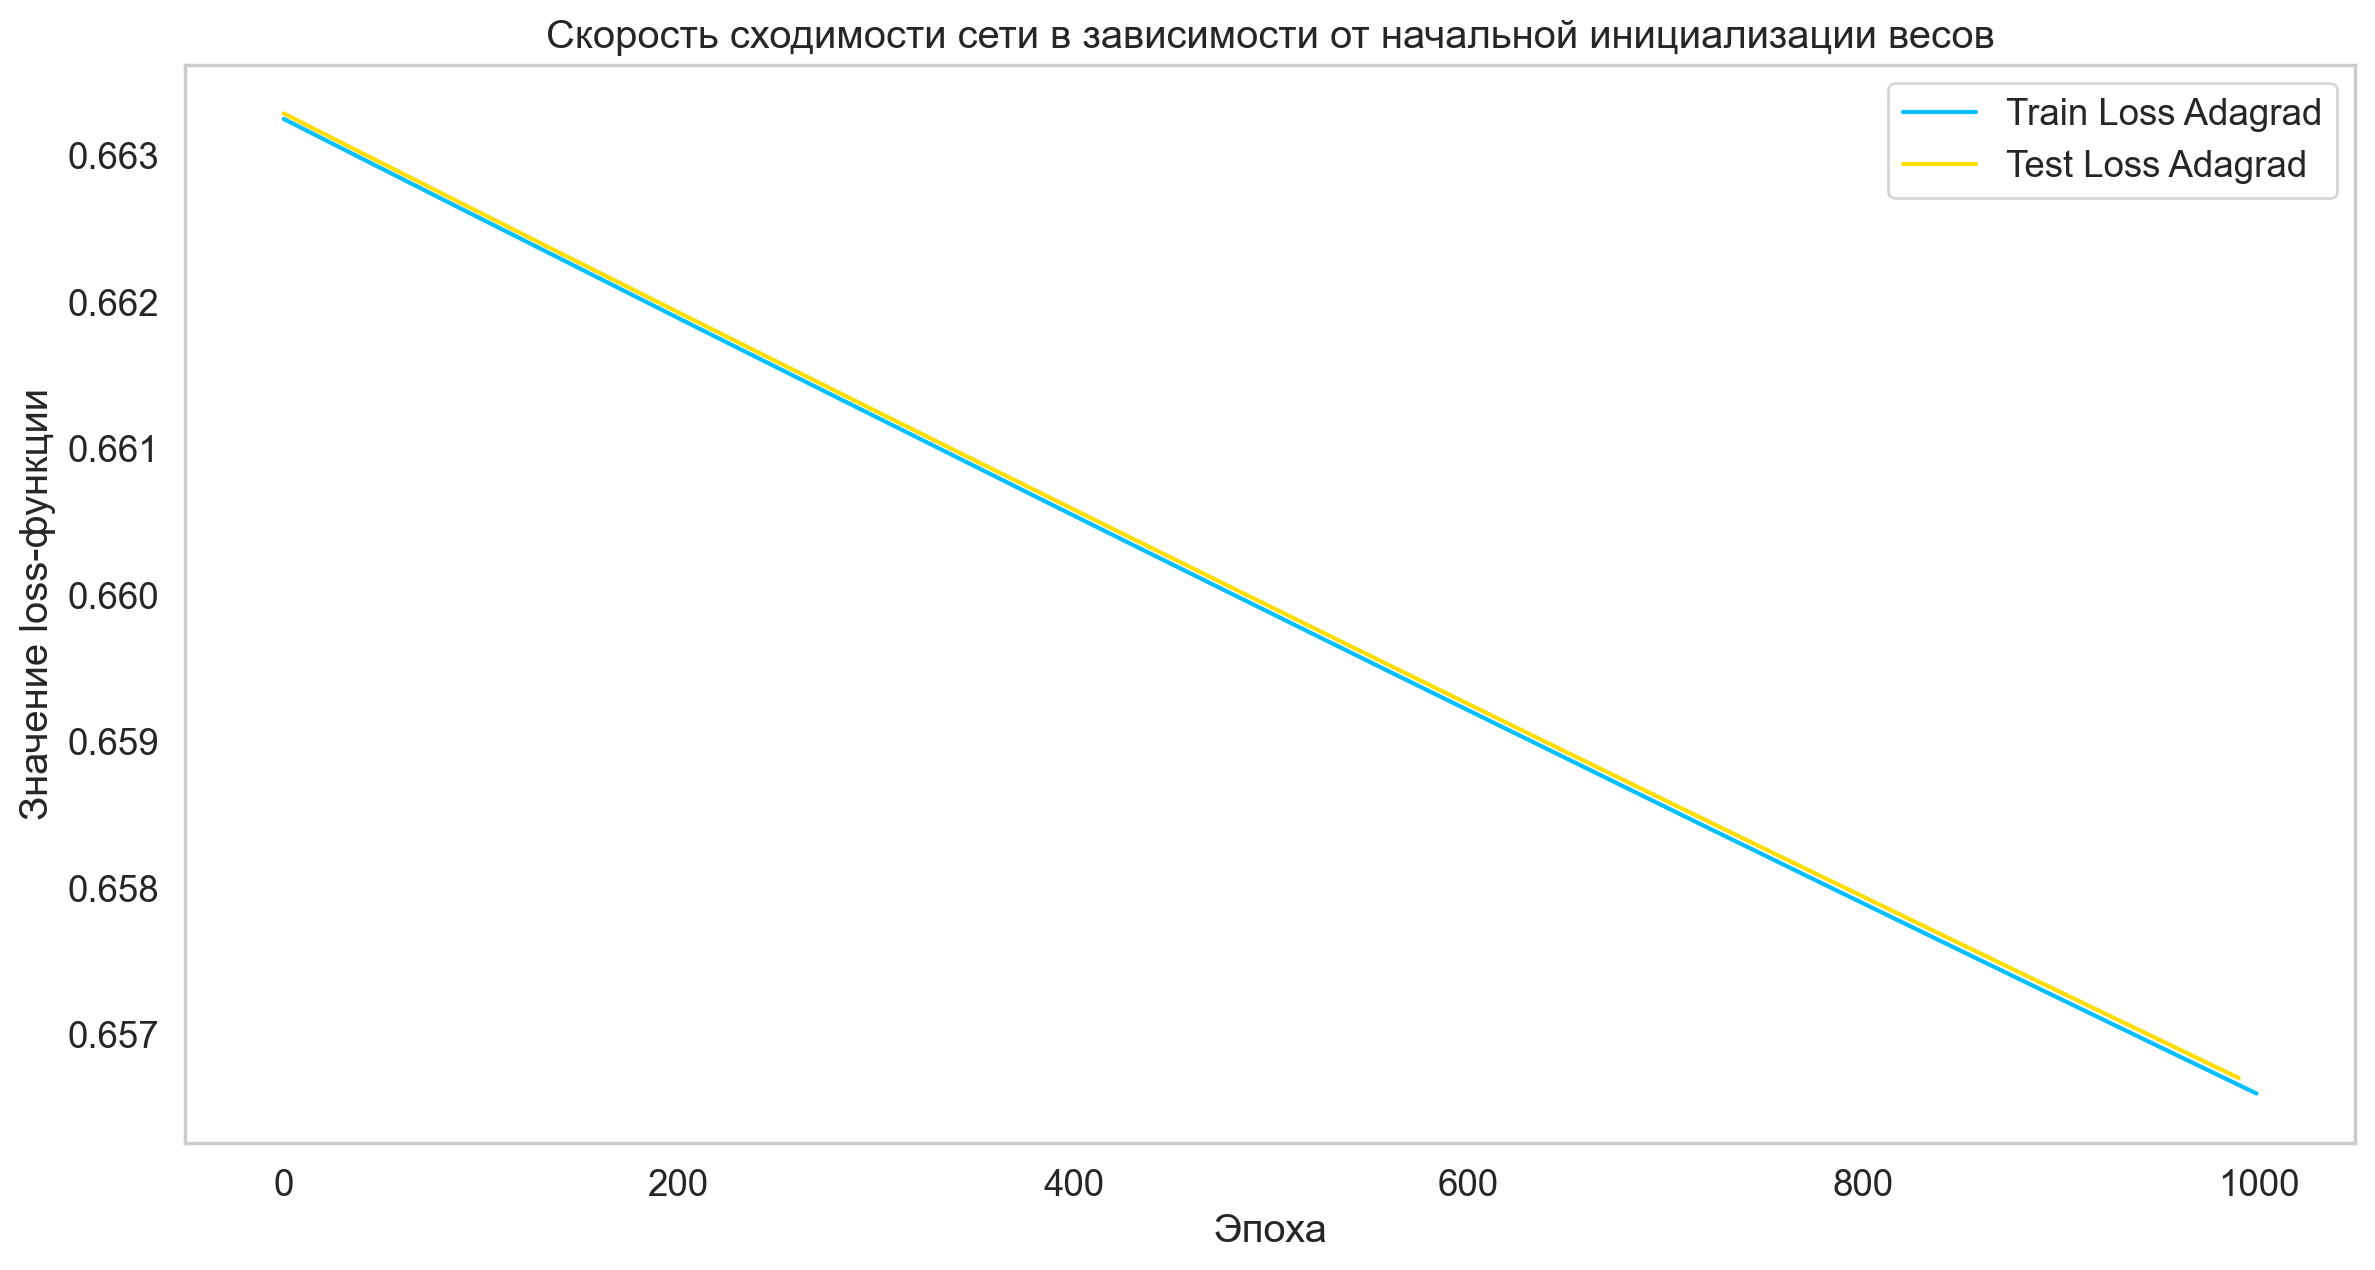

In [61]:
# 6. Исследуйте скорость сходимости сети в зависимости от начальной инициализации весов.


class Networkkk(nn.Module):
    def __init__(self, input_size, hidden_layers, activation_fn, weight_init):
        super(Networkkk, self).__init__()
        self.layers = nn.Sequential()
        last_size = input_size
        
        for i, layer_size in enumerate(hidden_layers):
            self.layers.add_module(f'fc{i+1}', nn.Linear(last_size, layer_size))
            self.layers.add_module(f'activation{i+1}', activation_fn)
            last_size = layer_size
        
        self.layers.add_module('output', nn.Linear(last_size, 1))
        
        self.apply(weight_init) 

    def forward(self, x):
        return torch.sigmoid(self.layers(x))


def train_and_evaluate(hidden_layers, activation_fn, weight_init, learning_rate=optimal_lr):
    net = Networkkk(4, hidden_layers, activation_fn, weight_init)
    criterion = nn.BCELoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    for epoch in range(1000):
        optimizer.zero_grad()
        y_pred = net(X_train).squeeze()
        train_loss = criterion(y_pred, y_train.float())
        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.item())

        if epoch % 10 == 0:
            y_test_pred = net(X_test).squeeze()
            test_loss = criterion(y_test_pred, y_test.float())
            test_losses.append(test_loss.item())

    return train_losses, test_losses


def init_weights(w):
    if isinstance(w, nn.Linear):
        nn.init.zeros_(w.weight)
    elif isinstance(w, nn.Linear):
        nn.init.normal_(w.weight, mean=0, std=0.01)
    elif isinstance(w, nn.Linear):
        nn.init.xavier_uniform_(w.weight)
    elif isinstance(w, nn.Linear):
        nn.init.xavier_uniform_(w.weight)

inits = ['Random', 'Zero', 'Xavier', 'Kaiming']

activation_fn = nn.LeakyReLU()
hidden_layers = [20, 20]

results = {}

for t in inits:
    print(f'using : {t}')
    train_losses, test_losses = train_and_evaluate(hidden_layers, activation_fn, init_weights)
    results[name] = {
        'train_loss': train_losses,
        'test_loss': test_losses,
        'final_test_loss': test_losses[-1] if test_losses else None
    }

plt.figure(figsize=(14, 7))

for name, data in results.items():
    plt.plot(data['train_loss'], label=f'Train Loss {name}')
    plt.plot(range(0, 1000, 10), data['test_loss'], label=f'Test Loss {name}')

plt.title('Скорость сходимости сети в зависимости от начальной инициализации весов')
plt.xlabel('Эпоха')
plt.ylabel('Значение loss-функции')
plt.legend()
plt.grid()
plt.show()